<a href="https://colab.research.google.com/github/bmajumderuos/GANs/blob/main/DeepConvolutionalGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepConvolutional(DC) GANs

Implementing the paper 'Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks' by Radforf et al. 2016, on the CelebA dataset.


In [ ]:
project_name = 'Deep_Convolutional(DC)GANs'

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle



In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bhaskarm
Your Kaggle Key: ··········


100%|██████████| 283M/283M [00:02<00:00, 103MB/s]


In [ ]:
import os

DATA_DIR = './celebahq-resized-256x256'
print(os.listdir(DATA_DIR))

['celeba_hq_256']


In [ ]:
print(os.listdir(DATA_DIR+'/celeba_hq_256')[:10])

['16520.jpg', '23503.jpg', '19563.jpg', '04267.jpg', '08776.jpg', '04067.jpg', '16220.jpg', '23227.jpg', '20639.jpg', '12542.jpg']


# The major points from the paper

• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator) - allowing it to learn its own spatial upsampling

• Use batchnorm in both the generator and the discriminator which stabilizes learning by normalizing the
input to each unit to have zero mean and unit variance. Circumvents poor initialization and helps gradient flow in deeper models. To avoid sample oscillation and model instability, batchnorm was excluded to the generator output layer and the discriminator input layer.

• Remove fully connected hidden layers on top of convolutional features. Global average pooling increased
model stability but hurt convergence speed. The first layer of the GAN, which takes a uniform noise distribution Z as input, could be called fully connected as it is just a matrix multiplication, but the result is reshaped into a 4-dimensional tensor and used as the start of the convolution stack. For the discriminator, the last convolution layer is flattened and then fed into a single sigmoid output

• Use ReLU activation in generator for all layers except for the output, which uses Tanh. Using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution

• Use LeakyReLU activation in the discriminator for all layers worked well especially for higher resolution modeling. This is in contrast to the original GAN paper, which used the maxout activation


# Network Architecture

<img src="https://www.researchgate.net/publication/340884113/figure/fig1/AS:883691647692803@1587699915828/DCGAN-Deep-Convolutional-Generative-Adversarial-Network-generator-used-for-LSUN.png" style="width:480px; margin-bottom:32px"/>


We will load the dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. Also create a data loader to load the data in batches.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn as nn

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  # To normalize the images between -1 & 1

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Helper functions to denormalize the image tensors and display some sample images from a training batch

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] #multiplies with std_dev & adds means

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

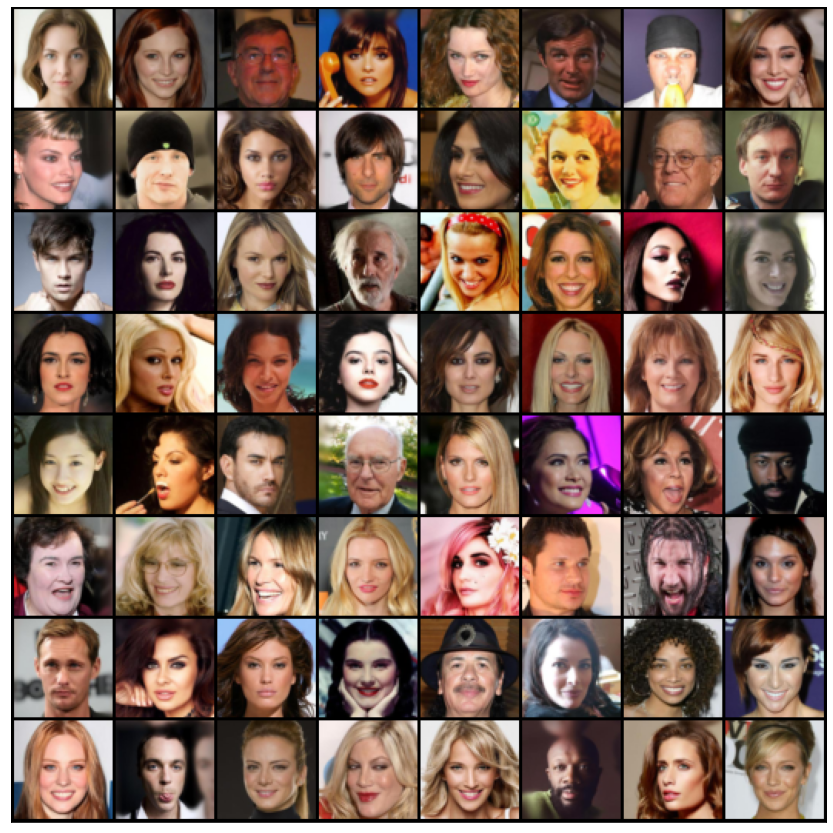

In [ ]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda')).
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Move our training data loader using DeviceDataLoader for automatically transferring batches of data to the GPU (if available)
train_dl = DeviceDataLoader(train_dl, device)


## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use kernel size of 4 & stride of 2(unlike in the graphics shown below) to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     The Batchnorm is excluded from the 1st layer of the discriminator
#     nn.BatchNorm2d(64),     
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()) 

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [ ]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(100, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [ ]:
latent_size = 100

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 100, 1, 1])
torch.Size([128, 3, 64, 64])


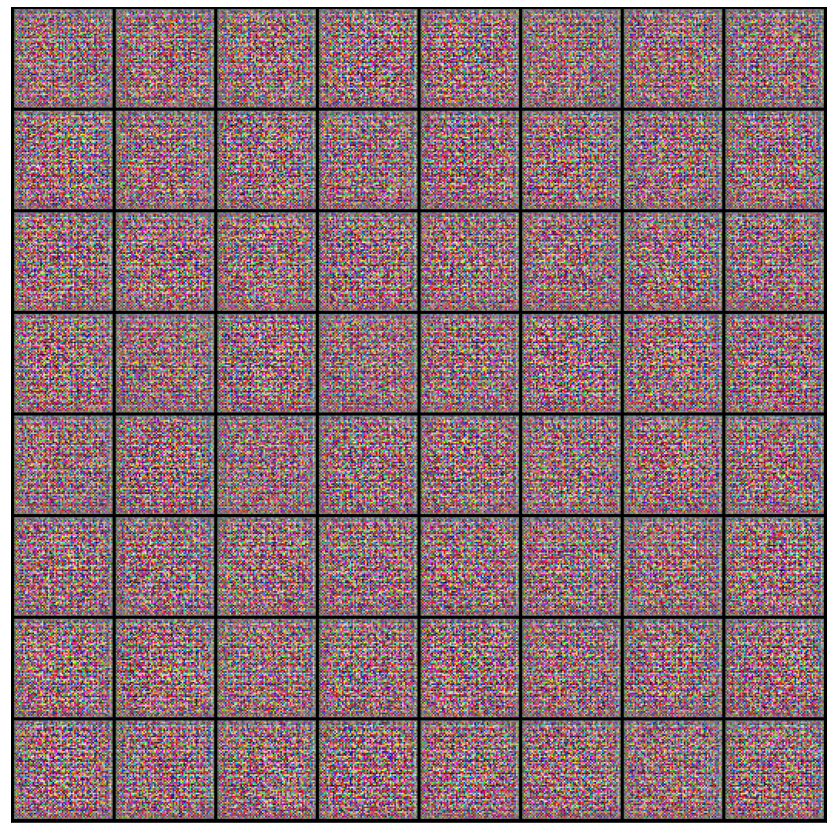

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As expected, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [ ]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Initialize weights
The paper suggests to initialize weights to a normal distribution of mean 0 & std dev 0.02

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [ ]:
initialize_weights(generator)
initialize_weights(discriminator)

Create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [ ]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


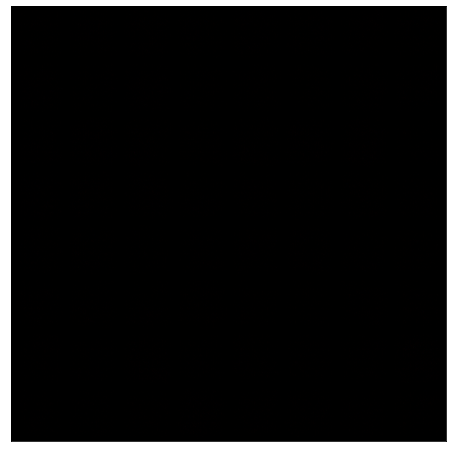

In [ ]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):  # Index for naming the files we save
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))   # Change only the parameter weights for the discriminator 
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))       # Change only the parameter weights for the generator
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):     # tqdm is helpful utility from the jupyter notebook to show a progress bar
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 15
history = fit(epochs, lr)

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 5.0148, loss_d: 0.0306, real_score: 0.9883, fake_score: 0.0185
Saving generated-images-0001.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 2.0524, loss_d: 0.5670, real_score: 0.6721, fake_score: 0.1032
Saving generated-images-0002.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 2.1144, loss_d: 0.6937, real_score: 0.6301, fake_score: 0.1595
Saving generated-images-0003.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 3.8156, loss_d: 0.7864, real_score: 0.7425, fake_score: 0.3615
Saving generated-images-0004.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 4.0515, loss_d: 1.2472, real_score: 0.8373, fake_score: 0.5986
Saving generated-images-0005.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 1.9989, loss_d: 0.8777, real_score: 0.5499, fake_score: 0.1384
Saving generated-images-0006.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 3.3743, loss_d: 0.7753, real_score: 0.7920, fake_score: 0.3719
Saving generated-images-0007.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 3.8792, loss_d: 1.0114, real_score: 0.8168, fake_score: 0.5110
Saving generated-images-0008.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 3.2858, loss_d: 0.6440, real_score: 0.8025, fake_score: 0.3091
Saving generated-images-0009.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 0.9572, loss_d: 2.5992, real_score: 0.1154, fake_score: 0.0057
Saving generated-images-0010.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 3.5935, loss_d: 0.5620, real_score: 0.8768, fake_score: 0.3128
Saving generated-images-0011.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 2.6787, loss_d: 0.5931, real_score: 0.7958, fake_score: 0.2678
Saving generated-images-0012.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 0.8202, loss_d: 0.9134, real_score: 0.5003, fake_score: 0.0571
Saving generated-images-0013.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 2.8739, loss_d: 0.5831, real_score: 0.8257, fake_score: 0.2880
Saving generated-images-0014.png


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 3.2985, loss_d: 0.7038, real_score: 0.8733, fake_score: 0.3967
Saving generated-images-0015.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Save checkpoints

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th and 15th epochs of training.

In [ ]:
from IPython.display import Image

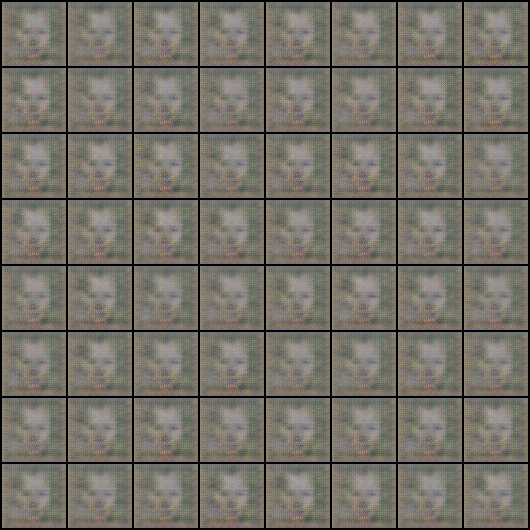

In [ ]:
Image('./generated/generated-images-0001.png')

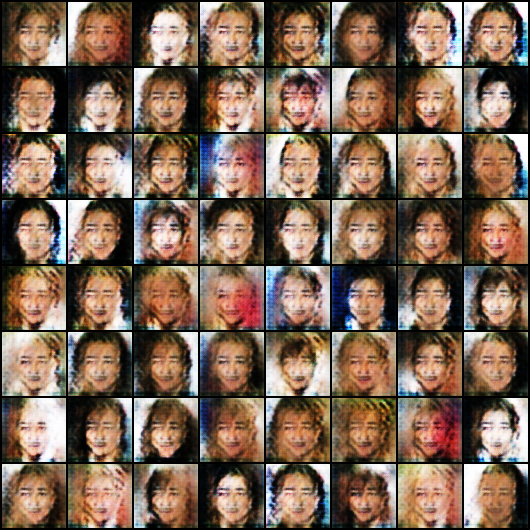

In [ ]:
Image('./generated/generated-images-0005.png')

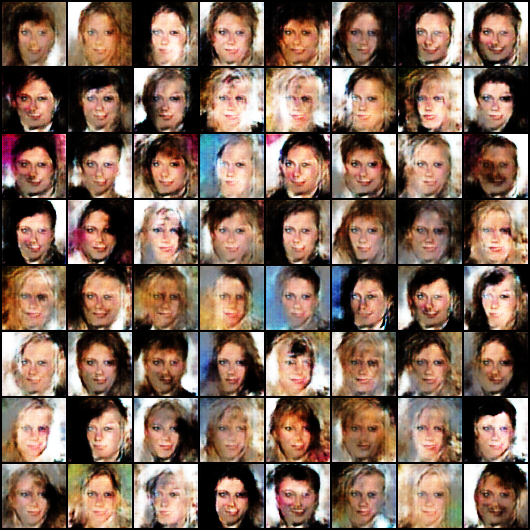

In [ ]:
Image('./generated/generated-images-0010.png')

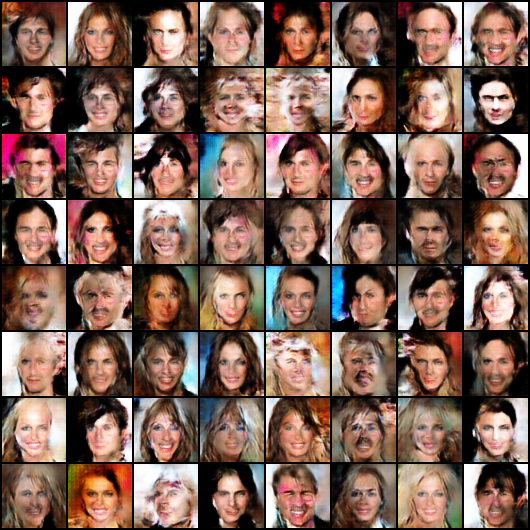

In [ ]:
Image('./generated/generated-images-0015.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [ ]:
import cv2
import os

vid_fname = 'dcgans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Visualize how the loss changes over time. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

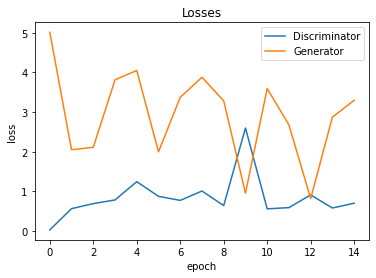

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

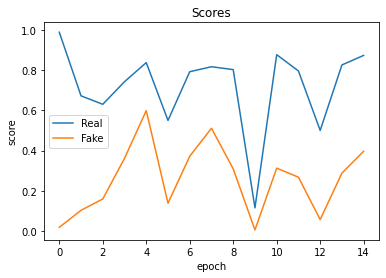

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

References:

1. Based on the Jovian course "Deep Learning with PyTorch - Image Generation using GANs" 
https://www.youtube.com/watch?v=79IvwU3G5_Q&list=PLyMom0n-MBroupZiLfVSZqK5asX8KfoHL&index=7

2. Also highly recommended resource, Aladdin Persson's GANs playlist
https://www.youtube.com/watch?v=OXWvrRLzEaU&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va 

## Save and Commit to my Jovian profile

Uploading the full snapshot of this experiment to Jovian:
- Jupyter notebook
- Hyperparameters & metrics
- Models weights
- Training video

Find more of my work at
https://jovian.com/meetbhaskarm/

In [ ]:
!pip install jovian --upgrade --quiet
import jovian

In [ ]:
jovian.log_hyperparams(lr=lr, epochs=epochs)

In [ ]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
